In [146]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import NearMiss
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [147]:
df = pd.read_csv("credit_card_transactions.csv")
df.head()

,TransactionID,Time,Amount,CardholderName,MerchantName,MCC,Location,Device,IPAddress,TransactionSpeed,Fraud
0,1,2025-03-09 06:23:57,83.54,Sarah Murray,Oconnor-Hughes,5411,Longtown,Android,102.247.49.50,38.17,0
1,2,2025-02-14 05:17:36,805.88,Alexander Brooks,Reed PLC,5261,Woodsland,POS,153.157.50.7,49.84,0
2,3,2024-05-03 15:28:52,450.49,Harold Perez,Berry LLC,5261,Jessicatown,iOS,151.174.154.123,48.79,0
3,4,2024-05-03 09:01:14,782.39,Rebecca Davis,Berg Inc,5968,North Krystalburgh,Android,130.70.79.149,8.71,0
4,5,2025-04-24 17:24:39,713.02,Lauren Benson DDS,King-Gaines,5968,East Danielletown,Android,195.136.16.190,17.16,0


In [148]:
df.dtypes

TransactionID         int64
Time                 object
Amount              float64
CardholderName       object
MerchantName         object
MCC                   int64
Location             object
Device               object
IPAddress            object
TransactionSpeed    float64
Fraud                 int64
dtype: object

In [149]:
#Transformacion de datos
df['Time'] = pd.to_datetime(df['Time'], errors = 'coerce')
df['MCC'] = df['MCC'].astype(object)
df['Weekday'] = df['Time'].dt.weekday
df['Hour'] = df['Time'].dt.hour
df['Month'] = df['Time'].dt.month

In [150]:
df.head()

,TransactionID,Time,Amount,CardholderName,MerchantName,MCC,Location,Device,IPAddress,TransactionSpeed,Fraud,Weekday,Hour,Month
0,1,2025-03-09 06:23:57,83.54,Sarah Murray,Oconnor-Hughes,5411,Longtown,Android,102.247.49.50,38.17,0,6,6,3
1,2,2025-02-14 05:17:36,805.88,Alexander Brooks,Reed PLC,5261,Woodsland,POS,153.157.50.7,49.84,0,4,5,2
2,3,2024-05-03 15:28:52,450.49,Harold Perez,Berry LLC,5261,Jessicatown,iOS,151.174.154.123,48.79,0,4,15,5
3,4,2024-05-03 09:01:14,782.39,Rebecca Davis,Berg Inc,5968,North Krystalburgh,Android,130.70.79.149,8.71,0,4,9,5
4,5,2025-04-24 17:24:39,713.02,Lauren Benson DDS,King-Gaines,5968,East Danielletown,Android,195.136.16.190,17.16,0,3,17,4


In [151]:
df.describe()

,TransactionID,Time,Amount,TransactionSpeed,Fraud,Weekday,Hour,Month
count,10000.00000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,2024-10-30 03:27:20.494300160,547.347491,30.738446,0.019200,2.995400,11.525500,6.528300
min,1.00000,2024-05-01 07:29:17,10.090000,0.110000,0.000000,0.000000,0.000000,1.000000
25%,2500.75000,2024-07-31 11:55:39.500000,263.222500,14.910000,0.000000,1.000000,6.000000,4.000000
50%,5000.50000,2024-10-30 22:49:50,512.240000,29.655000,0.000000,3.000000,12.000000,7.000000
75%,7500.25000,2025-01-28 03:57:06.750000128,759.935000,45.270000,0.000000,5.000000,17.000000,10.000000
max,10000.00000,2025-05-01 09:39:46,4988.070000,119.860000,1.000000,6.000000,23.000000,12.000000
std,2886.89568,NaN,460.047329,19.092345,0.137234,1.991626,6.932341,3.467795


In [152]:
df = df.drop(['CardholderName','TransactionID', 'Time', 'IPAddress'], axis=1)
df.isna().sum()

Amount              0
MerchantName        0
MCC                 0
Location            0
Device              0
TransactionSpeed    0
Fraud               0
Weekday             0
Hour                0
Month               0
dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x751d98271450>,
 'caps': [<matplotlib.lines.Line2D at 0x751d982716d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x751d98271310>],
 'medians': [<matplotlib.lines.Line2D at 0x751d98271950>],
 'fliers': [<matplotlib.lines.Line2D at 0x751d98271a90>],
 'means': []}

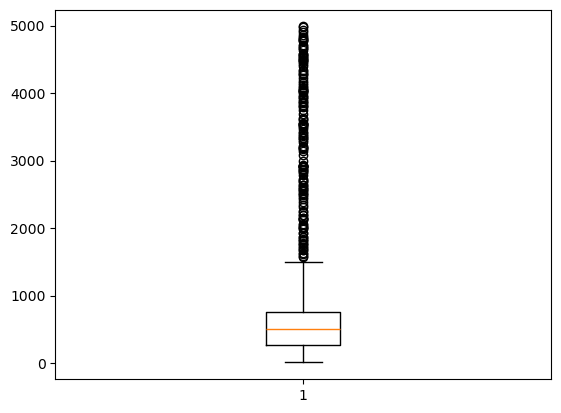

In [153]:
plt.boxplot(df['Amount'])

{'whiskers': [<matplotlib.lines.Line2D at 0x751d982dc550>,
 'caps': [<matplotlib.lines.Line2D at 0x751d982dc7d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x751d982dc410>],
 'medians': [<matplotlib.lines.Line2D at 0x751d982dca50>],
 'fliers': [<matplotlib.lines.Line2D at 0x751d982dcb90>],
 'means': []}

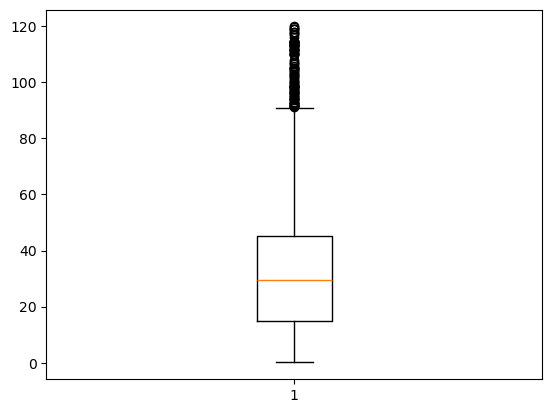

In [154]:
plt.boxplot(df['TransactionSpeed'])

In [155]:
# IQR Amount
q1 = df['Amount'].quantile(0.25)
q3 = df['Amount'].quantile(0.75)
iqr = q3 - q1

limite_superior = q3 + 1.5 * iqr

df['is_large_amount'] = (df['Amount'] > limite_superior).astype(int)


# IQR TransactionSpeed
q1 = df['TransactionSpeed'].quantile(0.25)
q3 = df['TransactionSpeed'].quantile(0.75)
iqr = q3 - q1

limite_superior = q3 + 1.5 * iqr

df['is_slow_transaction'] = (df['TransactionSpeed'] > limite_superior).astype(int)


In [156]:
#Data desbalanceada
df['Fraud'].value_counts()

Fraud
0    9808
1     192
Name: count, dtype: int64

In [157]:
#Calcular porcentajes de presencia en fraude y no fraude
#TODO

In [158]:
categoricFeatures = ['MerchantName','Location', 'MCC', 'Device']
numericFeatures = ['Amount', 'Hour', 'TransactionSpeed', 'is_slow_transaction', 'is_large_amount']
all_features = numericFeatures + categoricFeatures


#Normalizacion para categoricas
for col in categoricFeatures:
      df[col] = LabelEncoder().fit_transform(df[col])

#Normalizacion para numericas
df[all_features] = scaler.fit_transform(df[all_features])
df['Fraud'].value_counts()

Fraud
0    9808
1     192
Name: count, dtype: int64

In [159]:
X = df.drop('Fraud', axis=1)
y = df['Fraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [160]:
selector = SelectKBest(score_func=chi2, k='all')
selector.fit(X_train, y_train)

relevance = []

for feature, score in zip(X_train.columns, selector.scores_):
    relevance.append((feature, score))

relevance.sort(key=lambda x: x[1], reverse=True)

for feature, score in relevance:
    print(f"{feature}: {score:.2f}")

is_large_amount: 6368.51
is_slow_transaction: 4126.79
Amount: 306.06
TransactionSpeed: 154.70
Month: 3.95
Weekday: 0.41
MCC: 0.28
Hour: 0.19
Device: 0.16
MerchantName: 0.05
Location: 0.00


In [161]:
print("Distribución original en el conjunto de entrenamiento:")
print(pd.Series(y_train).value_counts())

Distribución original en el conjunto de entrenamiento:
Fraud
0    7846
1     154
Name: count, dtype: int64


### Aplicamos tecnica: NearMiss-3

In [162]:
nm = NearMiss(
    version=3,           # NearMiss-3
    n_neighbors=3,       # Número de vecinos para considerar
    n_neighbors_ver3=3   # Para versión 3, cuántos vecinos considerar para la selección
)

X_resampled, y_resampled = nm.fit_resample(X_train, y_train)

print("\nDistribución después de aplicar NearMiss-3:")
print(pd.Series(y_resampled).value_counts())


Distribución después de aplicar NearMiss-3:
Fraud
0    154
1    154
Name: count, dtype: int64


In [163]:
selector = SelectKBest(score_func=chi2, k='all')
selector.fit(X_resampled, y_resampled)

relevance = []

for feature, score in zip(X_train.columns, selector.scores_):
    relevance.append((feature, score))

relevance.sort(key=lambda x: x[1], reverse=True)

for feature, score in relevance:
    print(f"{feature}: {score:.2f}")

is_large_amount: 125.00
is_slow_transaction: 81.00
Amount: 44.19
TransactionSpeed: 23.14
Weekday: 1.24
Month: 0.63
Device: 0.57
MCC: 0.12
MerchantName: 0.07
Location: 0.07
Hour: 0.07


In [164]:
model = GaussianNB()
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

In [165]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1962
           1       1.00      0.84      0.91        38

    accuracy                           1.00      2000
   macro avg       1.00      0.92      0.96      2000
weighted avg       1.00      1.00      1.00      2000



In [166]:
print(confusion_matrix(y_test, y_pred))

[[1962    0]
 [   6   32]]
